In [4]:
import numpy as np
import pretty_midi
import matplotlib.pyplot as plt

DATA_DIR = "./"

In [5]:
midi_exp = pretty_midi.PrettyMIDI("./midi/AllOfMe.MID")

In [6]:
def find_bass_instrument(midi_data: pretty_midi.PrettyMIDI):
    for instr in midi_data.instruments:
        instr: pretty_midi.Instrument
        if instr.program == 32 and not instr.is_drum:
            return instr
    for instr in midi_data.instruments:
        instr: pretty_midi.Instrument
        if instr.program > 32 and instr.program <= 39 and not instr.is_drum:
            return instr

find_bass_instrument(midi_exp)

Instrument(program=32, is_drum=False, name="Bass    (BB)*gemischt")

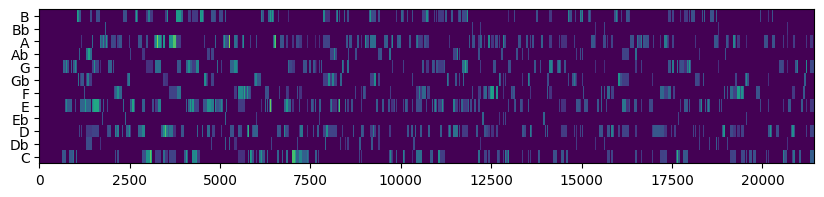

In [7]:
def plot_chromagram(chroma):
    fig, ax = plt.subplots()
    ax.imshow(chroma, origin="lower", aspect="auto", interpolation="none")
    fig.set_size_inches(10, 2)
    ax.set_yticks(list(range(12)))
    ax.set_yticklabels(["C", "Db", "D", "Eb", "E", "F", "Gb", "G", "Ab", "A", "Bb", "B"])
    plt.show()
plot_chromagram(midi_exp.get_chroma())

In [8]:
tempo_changes_time, tempo_changes_tempo = midi_exp.get_tempo_changes()
time_sig_changes = midi_exp.time_signature_changes

def get_three_scale_beats(midi_data: pretty_midi.PrettyMIDI):
    beats = midi_data.get_beats()
    down_beats = midi_data.get_downbeats()

    # add midi end time to beats and down_beats
    if down_beats[-1] < midi_data.get_end_time():
        down_beats = np.array(down_beats.tolist()+[midi_data.get_end_time()])
    if beats[-1] < midi_data.get_end_time():
        beats = np.array(beats.tolist()+[midi_data.get_end_time()])

    # obtain half_bar_beat
    half_bar_beat = []
    for i in range(len(down_beats)-1):
        half_bar_beat.append(down_beats[i])
        half_bar_beat.append((down_beats[i]+down_beats[i+1])/2)
    half_bar_beat.append(down_beats[-1])
    half_bar_beat = np.array(half_bar_beat)
    return beats, half_bar_beat, down_beats

beats, half_bar_beat, down_beats = get_three_scale_beats(midi_exp)

In [9]:
CHROMA_FS = 100

chroma = midi_exp.get_chroma(CHROMA_FS)
def get_three_scale_chroma(chroma, beats, down_beats):
    chroma_per_beat = []
    chroma_per_halfbar = []
    chroma_per_bar = []

    for i in range(len(beats)-1):
        left = int(beats[i]*CHROMA_FS)
        right = int(beats[i+1]*CHROMA_FS)
        chroma_per_beat.append(chroma[:, left:right].sum(axis=1))

    for i in range(len(down_beats)-1):
        left = int(down_beats[i]*CHROMA_FS)
        middle = int((down_beats[i]+down_beats[i+1])/2*CHROMA_FS)
        right = int(down_beats[i+1]*CHROMA_FS)

        chroma_per_halfbar.append(chroma[:, left:middle].sum(axis=1))
        chroma_per_halfbar.append(chroma[:, middle:right].sum(axis=1))
        chroma_per_bar.append(chroma[:, left:right].sum(axis=1))
    return chroma_per_beat,chroma_per_halfbar,chroma_per_bar

chroma_per_beat, chroma_per_halfbar, chroma_per_bar = get_three_scale_chroma(chroma, beats, down_beats)

print(np.array(chroma_per_beat).shape)
print(np.array(chroma_per_halfbar).shape)
print(np.array(chroma_per_bar).shape)

(404, 12)
(202, 12)
(101, 12)


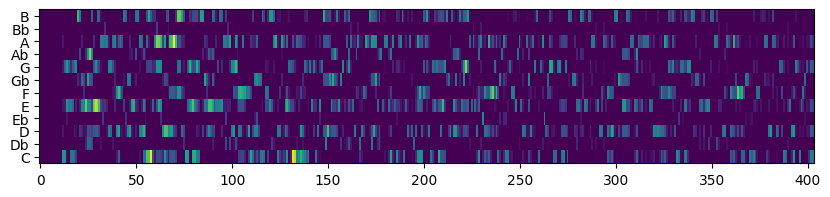

In [10]:
plot_chromagram(np.array(chroma_per_beat).T)

In [36]:
# TODO: how many drums?
def get_drum_rolls(midi_data: pretty_midi.PrettyMIDI):
    drum_rolls = []
    for instr in midi_data.instruments:
        instr: pretty_midi.Instrument
        if not instr.is_drum:
            continue
        roll = np.array([0]*int(midi_data.get_end_time()*CHROMA_FS))
        for note in instr.notes:
            note: pretty_midi.Note
            left = int(note.start*CHROMA_FS)
            right = int(note.end*CHROMA_FS)
            roll[left:right] = 1
        drum_rolls.append(roll)
    return np.array(drum_rolls)

drum_rolls = get_drum_rolls(midi_exp)

In [37]:
piano_rolls = [instr.get_piano_roll(CHROMA_FS) for instr in midi_exp.instruments]
drum_rolls = get_drum_rolls(midi_exp)

def get_number_of_simutaneously_played_instruments(piano_rolls, drum_rolls, left_t, right_t):
    left = int(left_t*CHROMA_FS)
    right = int(right_t*CHROMA_FS)
    count = 0
    for roll in piano_rolls:
        if (roll[:, left:right]!=0).any():
            count += 1
    for d_roll in drum_rolls:
        if (d_roll[left:right]!=0).any():
            count += 1
    return count

get_number_of_simutaneously_played_instruments(piano_rolls, drum_rolls, beats[212], beats[216])

3

In [39]:
def get_number_of_instruments_per_bar(piano_rolls, down_beats):
    instrument_per_bar = []
    for i in range(len(down_beats)-1):
        nospi = get_number_of_simutaneously_played_instruments(piano_rolls, drum_rolls, down_beats[i], down_beats[i+1])
        instrument_per_bar.append(nospi)
    return np.array(instrument_per_bar)

instrument_per_bar = get_number_of_instruments_per_bar(piano_rolls, down_beats)

In [41]:
instrument_per_bar[36:]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [14]:
def bass_midi_trim(bass_instr: pretty_midi.Instrument):
    for i in range(1, len(bass_instr.notes)):
        if bass_instr.notes[i].start < bass_instr.notes[i-1].end:
            bass_instr.notes[i-1].end = bass_instr.notes[i].start
    return bass_instr

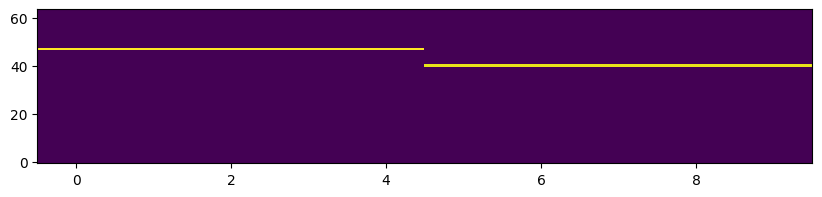

In [15]:
bpr = bass_midi_trim(find_bass_instrument(midi_exp)).get_piano_roll()[0:64,2725:2735]

fig, ax = plt.subplots()
ax.imshow(bpr, origin="lower", aspect="auto", interpolation="none")
fig.set_size_inches(10, 2)
# ax.set_yticks(list(range(12)))
# ax.set_yticklabels(["C", "Db", "D", "Eb", "E", "F", "Gb", "G", "Ab", "A", "Bb", "B"])
plt.show()

In [16]:
BASS_UPPER_BOUND = pretty_midi.note_name_to_number("Db5")
BASS_LOWER_BOUND = pretty_midi.note_name_to_number("B0")
BASS_REST_THRESH = 0.25
bass_piano_roll = bass_midi_trim(find_bass_instrument(midi_exp)).get_piano_roll()[BASS_LOWER_BOUND:BASS_UPPER_BOUND+1]

def get_bass_note_in_16th_note(piano_roll: np.ndarray, left_t, right_t):
    left = int(left_t*CHROMA_FS)
    right = int(right_t*CHROMA_FS)
    clip = piano_roll[:,left:right]
    clip = ((clip>0).astype(int)).sum(axis=1)
    
    ans = [0]*(BASS_UPPER_BOUND-BASS_LOWER_BOUND+2)
    if clip.sum() < (right-left+1)*BASS_REST_THRESH:
        ans[-1] = 1
    else:
        ans[np.argmax(clip)] = 1
    return np.array(ans)

get_bass_note_in_16th_note(bass_piano_roll, 30, 30.5)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In [17]:
half_bar_count = 0
bar_count = 0
beat_count = 0
tempo_change_count = 0
time_sig_changes_count = 0
tick_in_bar_count = 0

data_rows = []
bass_notes = []

for beat_count in range(len(beats)-1):
    if half_bar_count+1 < len(half_bar_beat) and beats[beat_count] >= half_bar_beat[half_bar_count+1]:
        half_bar_count += 1
    if bar_count+1 < len(down_beats) and beats[beat_count] >= down_beats[bar_count+1]:
        bar_count += 1
        tick_in_bar_count = 0
    
    if tempo_change_count+1 < len(tempo_changes_time) and beats[beat_count] >= tempo_changes_time[tempo_change_count+1]:
        tempo_change_count += 1
    if time_sig_changes_count+1 < len(time_sig_changes) and beats[beat_count] >= time_sig_changes[time_sig_changes_count+1].time:
        time_sig_changes_count += 1

    for i in range(4):
        row = []
        row.extend(chroma_per_beat[beat_count])
        row.extend(chroma_per_halfbar[half_bar_count])
        row.extend(chroma_per_bar[bar_count])
        row.append(tempo_changes_tempo[tempo_change_count])
        row.append(instrument_per_bar[bar_count])
        row.append(time_sig_changes[time_sig_changes_count].numerator)
        row.append(time_sig_changes[time_sig_changes_count].denominator)
        row.append(tick_in_bar_count)
        row.append(bar_count)
        data_rows.append(row)
        tick_in_bar_count += 1
    
        note_16th_left = (beats[beat_count]*(4-i)+beats[beat_count+1]*i)/4
        note_16th_right = (beats[beat_count]*(4-i-1)+beats[beat_count+1]*(i+1))/4
        bass_notes.append(get_bass_note_in_16th_note(bass_piano_roll, note_16th_left, note_16th_right))


In [18]:
def midi_to_input(path):
    midi_data = pretty_midi.PrettyMIDI(path)
    
    ## data preparation
    # beat time point
    beats, half_bar_beat, down_beats = get_three_scale_beats(midi_data)

    # chroma
    chroma = midi_data.get_chroma(CHROMA_FS)
    chroma_per_beat, chroma_per_halfbar, chroma_per_bar = get_three_scale_chroma(chroma, beats, down_beats)

    # instruments num per bar
    piano_rolls = [instr.get_piano_roll(CHROMA_FS) for instr in midi_data.instruments]
    instrument_per_bar = get_number_of_instruments_per_bar(piano_rolls, down_beats)

    # tempo_changes, time signature
    tempo_changes_time, tempo_changes_tempo = midi_data.get_tempo_changes()
    time_sig_changes = midi_data.time_signature_changes

    # bass part (ground truth)
    bass_track = bass_midi_trim(find_bass_instrument(midi_data))
    bass_piano_roll = bass_track.get_piano_roll()[BASS_LOWER_BOUND:BASS_UPPER_BOUND+1]
    

    ## run
    # count variable
    half_bar_count = 0
    bar_count = 0
    beat_count = 0
    tempo_change_count = 0
    time_sig_changes_count = 0
    tick_in_bar_count = 0

    # ans
    data_rows = []
    bass_notes = []

    for beat_count in range(len(beats)-1):
        # update bar, halfbar count
        if half_bar_count+1 < len(half_bar_beat) and beats[beat_count] >= half_bar_beat[half_bar_count+1]:
            half_bar_count += 1
        if bar_count+1 < len(down_beats) and beats[beat_count] >= down_beats[bar_count+1]:
            bar_count += 1
            tick_in_bar_count = 0
        
        # update tempo, time signature
        if tempo_change_count+1 < len(tempo_changes_time) and beats[beat_count] >= tempo_changes_time[tempo_change_count+1]:
            tempo_change_count += 1
        if time_sig_changes_count+1 < len(time_sig_changes) and beats[beat_count] >= time_sig_changes[time_sig_changes_count+1].time:
            time_sig_changes_count += 1

        for i in range(4):
            # input part
            row = []
            row.extend(chroma_per_beat[beat_count])
            row.extend(chroma_per_halfbar[half_bar_count])
            row.extend(chroma_per_bar[bar_count])
            row.append(tempo_changes_tempo[tempo_change_count])
            row.append(instrument_per_bar[bar_count])
            row.append(time_sig_changes[time_sig_changes_count].numerator)
            row.append(time_sig_changes[time_sig_changes_count].denominator)
            row.append(tick_in_bar_count)
            row.append(bar_count)
            data_rows.append(row)
            tick_in_bar_count += 1

            # ground truth part
            note_16th_left = (beats[beat_count]*(4-i)+beats[beat_count+1]*i)/4
            note_16th_right = (beats[beat_count]*(4-i-1)+beats[beat_count+1]*(i+1))/4
            bass_notes.append(get_bass_note_in_16th_note(bass_piano_roll, note_16th_left, note_16th_right))
    return np.array(data_rows), np.array(bass_notes)